<h1>Experiments with feature detection algorithms</h1>

The goal is to test / develop algorithms for automated spectral line detection. These will eventually make their way into a specviz plug-in.

(from ticket #304):

The simplest useful detection algorithm is the following:

 - Convolve the spectrum with a fixed kernel (usually a Gaussian with FWHM corresponding to the spectral resolution).
 - Divide by the RMS noise and search for pixels above or below a fixed S/N threshold. These are the emission or absorption line centers.


In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline
# constants for all plots
x_label = '$\lambda$($\AA$)'
y_label = 'erg.cm$^{-2}$.s$^{-1}$.$A^{-1}$'
SIZE = (16, 3)
plot_scale = (1130., 1480., -15., 15.)
zero_line = [(plot_scale[0], plot_scale[1]),(0.,0.)]

<h3>Get raw data</h3>

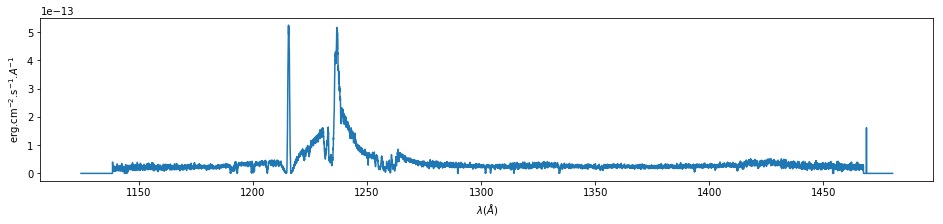

In [2]:
hdulist = fits.open('data/combined_13330_G130M_v40_bin4.fits')
flux = hdulist[1].data['flux'][0]
wave = hdulist[1].data['wavelength'][0]

plt.figure(figsize=SIZE)
plt.plot(wave, flux)
plt.xlabel(x_label)
plt.ylabel(y_label)

<h3>Convolve </h3>

In [3]:
from astropy.convolution import convolve, Gaussian1DKernel

gauss = Gaussian1DKernel(stddev=3)

convolved_flux = convolve(flux, gauss)

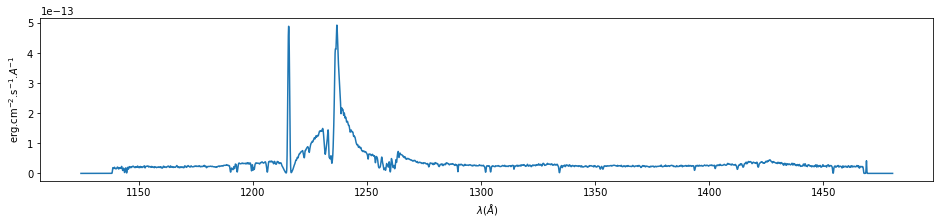

In [4]:
plt.figure(figsize=SIZE)
plt.plot(wave, convolved_flux)
plt.xlabel(x_label)
plt.ylabel(y_label)

<h3>Normalize by RMS noise</h3>

Do the dumb thing and pick a region by eye. A real-world algorithm needs to do better than that.

In [5]:
indices = (wave > 1360.) & (wave < 1380.) 
f1 = flux[indices]
rms = np.std(f1)

normalized_flux = convolved_flux / rms

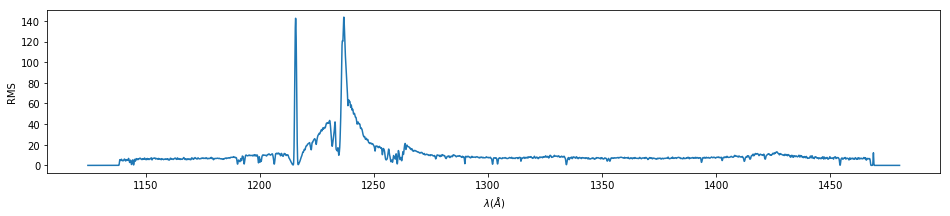

In [6]:
plt.figure(figsize=SIZE)
plt.plot(wave, normalized_flux)
plt.xlabel(x_label)
plt.ylabel('RMS')

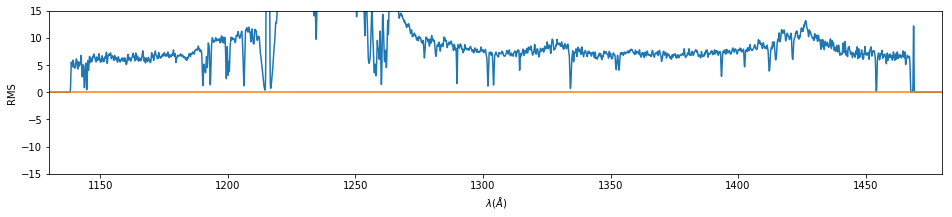

In [7]:
plt.figure(figsize=SIZE)
plt.plot(wave, normalized_flux)
plt.plot(zero_line[0], zero_line[1])
plt.axis(plot_scale)
plt.xlabel(x_label)
plt.ylabel('RMS')

The algorithm as stated above won't work because of continuum subtraction. Lets add a naive implementation to see where it takes us.

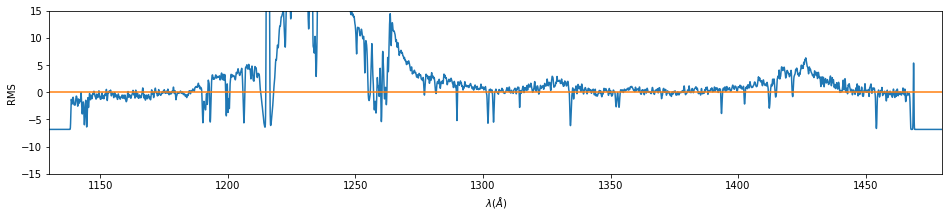

In [8]:
mean = np.median(f1) # median is less affected by outliers

normalized_flux = (convolved_flux - mean) / rms

plt.figure(figsize=SIZE)
plt.plot(wave, normalized_flux)
plt.plot(zero_line[0], zero_line[1])
plt.axis(plot_scale)
plt.xlabel(x_label)
plt.ylabel('RMS')

<h3>Search for points above and/or below a threshold</h3>

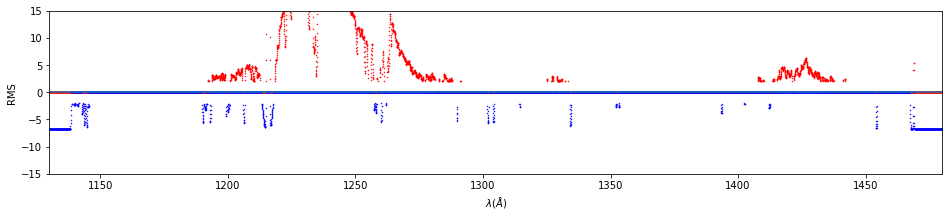

In [9]:
threshold = 2.

out = np.where(normalized_flux < threshold)
normalized_flux[out] = 0.

normalized_flux_2 = (convolved_flux - mean) / rms
out = np.where(normalized_flux_2 > -threshold)
normalized_flux_2[out] = 0.

plt.figure(figsize=SIZE)
plt.plot(wave, normalized_flux, '.', color='r', markersize=1)
plt.plot(wave, normalized_flux_2, '.', color='b', markersize=1)
plt.plot(zero_line[0], zero_line[1])
plt.axis(plot_scale)
plt.xlabel(x_label)
plt.ylabel('RMS')

Clearly, we cannot use this to pinpoint spectral lines. A better algorithm may be one that looks for the first derivative zero crossings. We will give a shot at this one: https://terpconnect.umd.edu/~toh/spectrum/PeakFindingandMeasurement.htm 

with Matlab code in here: https://terpconnect.umd.edu/~toh/spectrum/findpeaksx.m
